# **Import Semua yg Dibutuhkan**

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

# **Menyiapkan Dataset**

In [2]:
!wget --no-check-certificate \
  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv \
  -O /tmp/bbc-text.csv

--2022-04-14 02:54:56--  https://storage.googleapis.com/dataset-uploader/bbc/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.201.128, 74.125.202.128, 173.194.193.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.201.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [text/csv]
Saving to: ‘/tmp/bbc-text.csv’

/tmp/bbc-text.csv   100%[===================>]   4.82M  --.-KB/s    in 0.05s   

2022-04-14 02:54:56 (89.9 MB/s) - ‘/tmp/bbc-text.csv’ saved [5057493/5057493]



In [3]:
df = pd.read_csv('/tmp/bbc-text.csv')
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


# **One Hot Encoding**


In [4]:
category = pd.get_dummies(df.category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,text,business,entertainment,politics,sport,tech
0,tv future in the hands of viewers with home th...,0,0,0,0,1
1,worldcom boss left books alone former worldc...,1,0,0,0,0
2,tigers wary of farrell gamble leicester say ...,0,0,0,1,0
3,yeading face newcastle in fa cup premiership s...,0,0,0,1,0
4,ocean s twelve raids box office ocean s twelve...,0,1,0,0,0
...,...,...,...,...,...,...
2220,cars pull down us retail figures us retail sal...,1,0,0,0,0
2221,kilroy unveils immigration policy ex-chatshow ...,0,0,1,0,0
2222,rem announce new glasgow concert us band rem h...,0,1,0,0,0
2223,how political squabbles snowball it s become c...,0,0,1,0,0


# **Mengubah Nilai-nilai Dataframe ke dalam Numpy Array**

In [5]:
text = df_baru['text'].values
label = df_baru[['business', 'entertainment', 'politics', 'sport', 'tech']]

In [7]:
train_text, test_text, train_label, test_label = train_test_split(text, label, test_size=0.2)

# **Tokenizer**

In [8]:
tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(train_text)
tokenizer.fit_on_texts(test_text)

train_seq = tokenizer.texts_to_sequences(train_text)
test_seq = tokenizer.texts_to_sequences(test_text)

train_padded = pad_sequences(train_seq)
test_padded = pad_sequences(test_seq)

# **Callback**

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.97):
      print("\nAkurasi mencapai 97%, training berhenti")
      self.model.stop_training = True

callbacks = myCallback()

# **Model Sequential**

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=5000, output_dim=16),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax'),
])

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          80000     
                                                                 
 lstm (LSTM)                 (None, 64)                20736     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 5)                 325       
                                                                 
Total params: 117,637
Trainable params: 117,637
Non-trainable params: 0
_________________________________________________________________


# **Melatih Model**

In [11]:
num_epochs = 30
history = model.fit(train_padded,
                    train_label,
                    epochs=num_epochs,
                    validation_data=(test_padded, test_label),
                    verbose = 2,
                      callbacks = [callbacks]
                    )

Epoch 1/30
56/56 - 32s - loss: 1.6025 - accuracy: 0.2320 - val_loss: 1.5956 - val_accuracy: 0.2315 - 32s/epoch - 573ms/step
Epoch 2/30
56/56 - 25s - loss: 1.4761 - accuracy: 0.3860 - val_loss: 1.2836 - val_accuracy: 0.4360 - 25s/epoch - 448ms/step
Epoch 3/30
56/56 - 25s - loss: 1.0145 - accuracy: 0.5388 - val_loss: 0.9367 - val_accuracy: 0.5708 - 25s/epoch - 448ms/step
Epoch 4/30
56/56 - 25s - loss: 0.6162 - accuracy: 0.7180 - val_loss: 1.1393 - val_accuracy: 0.5596 - 25s/epoch - 448ms/step
Epoch 5/30
56/56 - 25s - loss: 0.3814 - accuracy: 0.8584 - val_loss: 0.9512 - val_accuracy: 0.6764 - 25s/epoch - 450ms/step
Epoch 6/30
56/56 - 25s - loss: 0.2474 - accuracy: 0.9118 - val_loss: 1.0603 - val_accuracy: 0.7101 - 25s/epoch - 447ms/step
Epoch 7/30

Akurasi mencapai 97%, training berhenti
56/56 - 25s - loss: 0.0959 - accuracy: 0.9719 - val_loss: 1.2279 - val_accuracy: 0.6899 - 25s/epoch - 447ms/step


# **Plot Akurasi dan Loss**

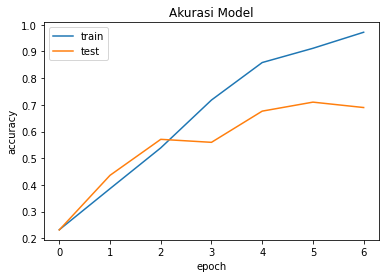

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

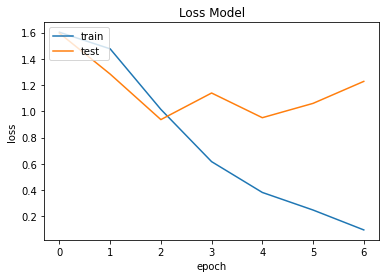

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()